In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AF-sMoYPplS0mugymntBeR4Pq0s03IyLl6Cv64R83FhbM_puIt1IME
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/1332faces.zip' -d '/content/imgData'

In [3]:
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib import cm

In [23]:
def imgPilList(filePath):
  image_list = []
  for filename in glob.glob(filePath):
    im = Image.open(filename)
    image_list.append(im)
  return image_list

cwd = '/content/imgData/dataset'

filePath = cwd + "//0001-3000//*.jpg"
# filePath = cwd + "//6001-9000//*.jpg"
# filePath = cwd + "//9001-13322//*.jpg"

origin_img_data = imgPilList(filePath)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=309x398 at 0x7EFF8B822780>


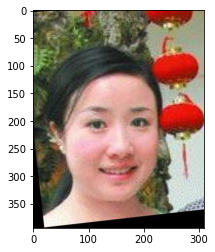

In [24]:
print(origin_img_data[0])
plt.imshow(origin_img_data[2])

In [42]:
standardize_image_shape = (64, 64)
def resizeImg(image, ideal_width, ideal_height):
    width  = image.size[0]
    height = image.size[1]
    aspect = width / float(height)
    ideal_aspect = ideal_width / float(ideal_height)
    if aspect > ideal_aspect:
      # Then crop the left and right edges:
      new_width = int(ideal_aspect * height)
      offset = (width - new_width) / 2
      resize = (offset, 0, width - offset, height)
    else:
      # ... crop the top and bottom:
      new_height = int(width / ideal_aspect)
      offset = (height - new_height) / 2
      resize = (0, offset, width, height - offset)
    thumb = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)
    return thumb
  
# 灰階轉換公式
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def plot_gallery(title, images, n_col, n_row, cmap=plt.cm.gray, image_shape=image_shape):
    plt.figure(figsize=(2. * n_row, 2.26 * n_col))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

def standardized_img_list(imgList, idealImgShape):
  imgCollected = []
  width = idealImgShape[0]
  height = idealImgShape[1]
  for img in imgList:
    img = resizeImg(image = img, ideal_width = width, ideal_height = height)
    image_sequence = img.getdata()
    image_array = np.array(image_sequence)
    imgCollected.append(rgb2gray(image_array) / 255)
  outputModel = np.array(imgCollected)
  return outputModel

def plotImgFromVector(vec, imgShape):
  shape_with = imgShape[0]
  shape_heigth = imgShape[1]
  resizeImg = np.reshape(vec, (shape_with, shape_heigth))
  outputModel = Image.fromarray(np.uint8(cm.gist_earth(resizeImg)* 255))
  return outputModel

In [43]:
standardized_img_data = standardized_img_list(origin_img_data, standardize_image_shape)

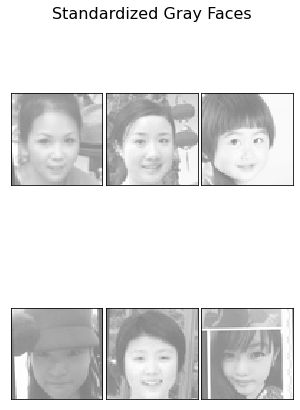

In [36]:
plotIndex = 1
plot_gallery("Standardized Gray Faces", standardized_img_data[plotIndex:plotIndex + 6], n_col = 3, n_row = 2)

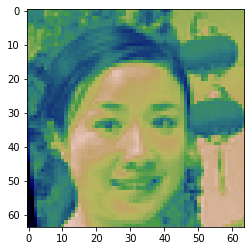

In [39]:
im = plotImgFromVector(standardized_img_data[2], 64, 64)
plt.imshow(im)

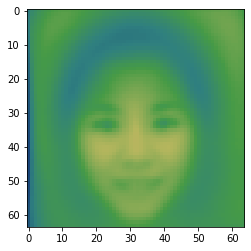

In [16]:
meanFace = np.mean(trainFaces, axis=0)
plt.imshow(plotImgFromVector(meanFace, 64, 64))

# PCA

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [17]:
from sklearn.decomposition import PCA
from time import time

Simple PCA

In [ ]:
X_train = trainFaces
print("X_train shape", X_train.shape)
n_samples = trainFaces.shape[0]
h = 64
w = 64
n_components = 256

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time() #計時
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
#進行降維
X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

X_train shape (3000, 4096)
Extracting the top 256 eigenfaces from 3000 faces
done in 4.556s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.237s


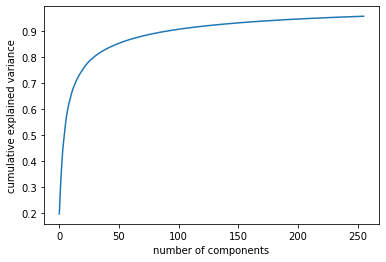

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
print(eigenfaces.shape)
plot_gallery("Eigen Face", eigenfaces[1:64], 8, 8)

In [ ]:
# Plot the results
projected = pca.inverse_transform(components)
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

NameError: ignored

In [ ]:
print("pca components", pca.components_.shape, pca.components_)

pca components (256, 4096) [[ 0.0158033   0.02028939  0.02141767 ...  0.01588492  0.01642938
   0.01639368]
 [-0.00515477 -0.00635097 -0.00774562 ... -0.00299433 -0.0028377
  -0.00329888]
 [-0.00400368 -0.0064668  -0.00638884 ... -0.01696555 -0.01734852
  -0.01775063]
 ...
 [ 0.02383513  0.00999733  0.03629052 ... -0.01123804 -0.00759343
  -0.0069769 ]
 [-0.00932781  0.03016741  0.00410963 ...  0.01572101  0.00655987
  -0.00245531]
 [-0.02888609 -0.01554701  0.00119155 ... -0.00364447  0.01460763
   0.01845767]]


In [ ]:
print("pca variance", pca.explained_variance_.shape)
print("pca variance", pca.explained_variance_)

pca variance (256,)
pca variance [7.60977854e+01 3.17100684e+01 1.98601832e+01 1.59766241e+01
 1.07184797e+01 1.00928589e+01 8.30277014e+00 6.34709562e+00
 5.25893310e+00 4.35566755e+00 3.63417554e+00 3.42731753e+00
 3.25024391e+00 2.54639536e+00 2.51269174e+00 2.01254793e+00
 1.93942397e+00 1.69537131e+00 1.53255006e+00 1.45338571e+00
 1.40316348e+00 1.38325995e+00 1.29451645e+00 1.27803817e+00
 1.12583314e+00 1.06957373e+00 1.02227836e+00 9.69079918e-01
 9.19816497e-01 8.71691708e-01 8.52801691e-01 8.05125615e-01
 7.70188986e-01 7.17443411e-01 6.87774481e-01 6.55314749e-01
 6.11441925e-01 6.02490244e-01 5.82765263e-01 5.64650633e-01
 5.47252853e-01 5.39715300e-01 5.10294883e-01 4.87856236e-01
 4.83532256e-01 4.59786470e-01 4.58418475e-01 4.51540126e-01
 4.36115942e-01 4.25084444e-01 4.05570698e-01 4.03250327e-01
 3.95937420e-01 3.89177639e-01 3.74231556e-01 3.66136900e-01
 3.54594442e-01 3.48019113e-01 3.39613346e-01 3.35530082e-01
 3.22619157e-01 3.17510393e-01 3.14461470e-01 3.0413

In [ ]:
print("pca variance ratio", pca.explained_variance_ratio_.shape)
print("pca variance ratio", pca.explained_variance_ratio_)

pca variance ratio (256,)
pca variance ratio 256


In [ ]:
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
from numpy.random import RandomState
from time import time
import logging

In [ ]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [ ]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,random_state=RandomState(0))
faces = trainFaces

n_samples, n_features = faces.shape
print(faces.shape)

(3000, 4096)


In [ ]:
# global centering
faces_centered = faces - faces.mean(axis=0)

In [ ]:
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 3000 faces


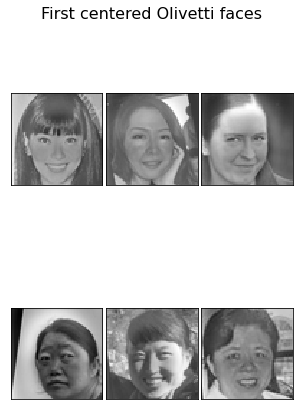

In [ ]:
plot_gallery("First centered Olivetti faces", faces_centered[:n_components], n_col, n_row)

In [ ]:
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=20),
     True),
]

Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.707s
Extracting the top 6 Non-negative components - NMF...
done in 6.090s
Extracting the top 6 Independent components - FastICA...
done in 26.475s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 4.264s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 1.443s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.481s
Extracting the top 6 Factor Analysis components - FA...
done in 2.364s


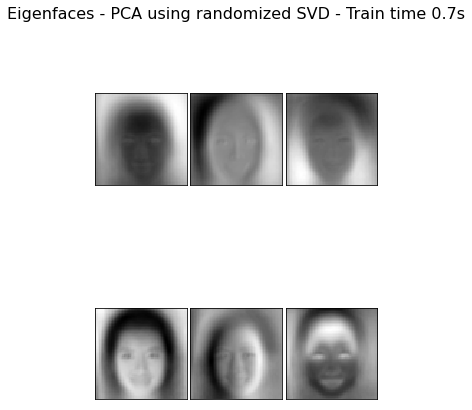

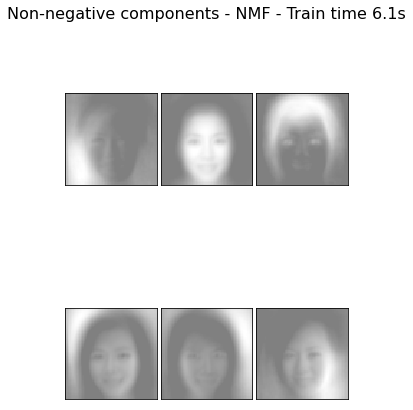

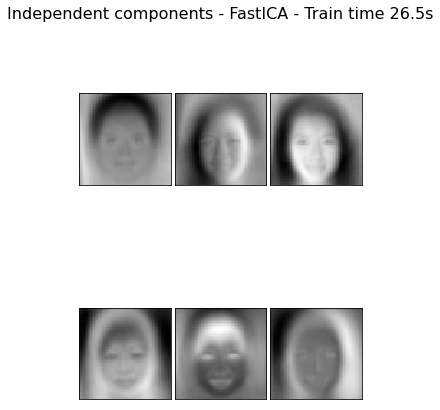

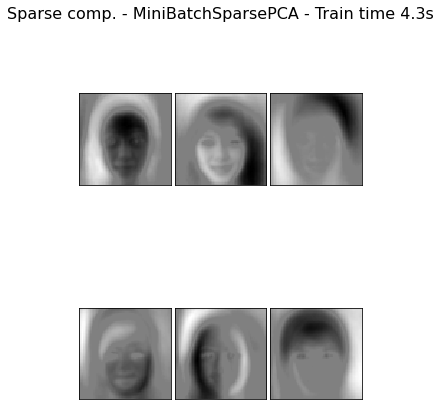

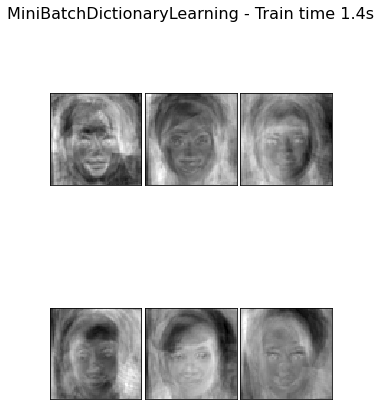

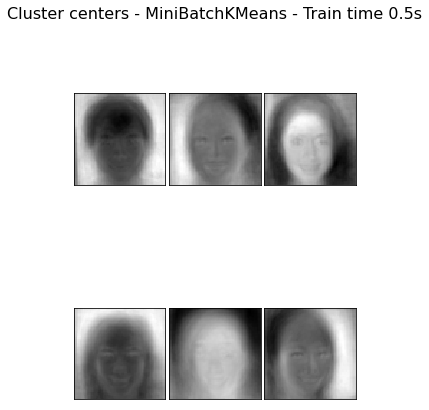

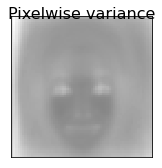

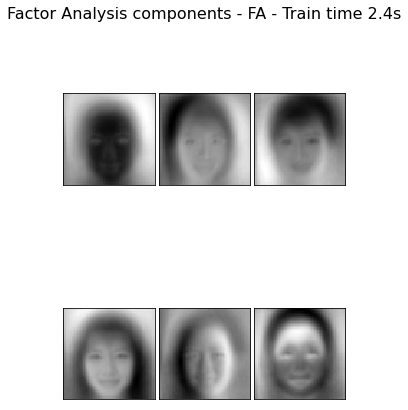

In [ ]:
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components], 3, 2)

plt.show()

In [ ]:
# Various positivity constraints applied to dictionary learning.
estimators = [
    ('Dictionary learning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),
    ('Dictionary learning - positive dictionary',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_dict=True),
     True),
    #('Dictionary learning - positive code',
    #    decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
    #                                              n_iter=50, batch_size=3,
    #                                              fit_algorithm='cd',
    #                                              random_state=rng,
    #                                              positive_code=True),
    # True),
    # ('Dictionary learning - positive dictionary & code',
    #     decomposition.MiniBatchDfictionaryLearning(n_components=15, alpha=0.1,
    #                                                n_iter=50, batch_size=3,
    #                                                fit_algorithm='cd',
    #                                                random_state=rng,
    #                                                positive_dict=True,
    #                                                positive_code=True),
    #  True),
]

Extracting the top 6 Dictionary learning...
done in 1.492s
Extracting the top 6 Dictionary learning - positive dictionary...
done in 1.473s


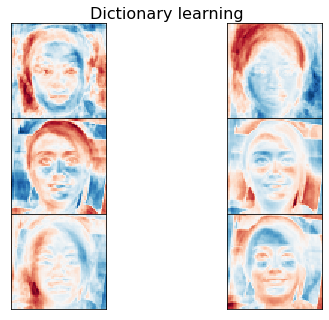

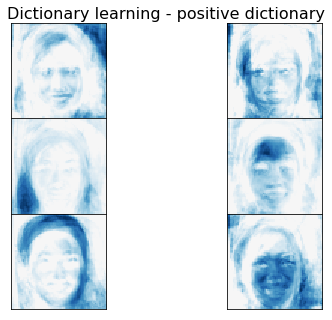

In [ ]:
for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery(name, components_[:n_components], 2, 3, cmap=plt.cm.RdBu)

plt.show()

In [ ]:
print(trainFaces.shape[0])

3000


# 臉部分群

https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/

In [ ]:
# DBSCAN 
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [ ]:
X = X_train_pca
print(X)

[[ 0.24876909  0.19811043 -1.10404842 ...  1.78281979 -0.96606367
   0.81441944]
 [-0.88333208 -0.17582101  1.10658406 ...  0.38178417 -1.22547932
  -1.93259374]
 [-1.07949183 -1.23642981 -0.00284667 ... -0.33502849  0.70704757
  -0.13544233]
 ...
 [ 0.47829354  0.84515976 -0.80192467 ... -0.10012481 -1.32632235
  -0.51031072]
 [ 2.10597432 -0.42128078 -1.68623116 ... -0.10978389 -0.59842846
  -0.76566432]
 [-1.36160433  0.21990299  0.75267773 ... -0.51455287  1.09381268
   0.60908753]]


In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 0
Estimated number of noise points: 3000


NameError: ignored

In [ ]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [ ]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)


In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))


In [ ]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Chinese-Whisper分類演算法

https://www.itread01.com/content/1544826095.html
Library: https://github.com/nlpub/chinese-whispers-python

In [ ]:
import networkx as nx
from chinese_whispers import chinese_whispers, aggregate_clusters
import matplotlib as plt

In [ ]:
# chinese_whispers(G, weighting='top', iterations=20)
G = nx.karate_club_graph()

# Perform clustering of G, parameters weighting and seed can be omitted
chinese_whispers(G, weighting='top', seed=1337) 

# Print the clusters in the descending order of size
print('ID\tCluster\n')

for label, cluster in sorted(aggregate_clusters(G).items(), key=lambda e: len(e[1]), reverse=True):
    print('{}\t{}\n'.format(label, cluster))



AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

colors = [1. / G.nodes[node]['label'] for node in G.nodes()]

nx.draw_networkx(G, cmap=plt.get_cmap('jet'), node_color=colors, font_color='white')

KeyError: ignored